In [1]:
from __future__ import print_function, division, absolute_import
from collections import Counter
import os
import sys
import orbithunter as orb
import numpy as np
import matplotlib.pyplot as plt
import time

# Learning symbolic representations with Deep Learning .

This notebook mainly serves as an introduction for how one might use deep learning to create a predictive deep learning model for various equations. It is not too extensive now as it mainly serves as a simple introduction as to how one might want to
use a predictive model for statistical averages of turbulence

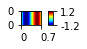

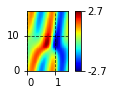

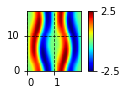

In [2]:
td = orb.read_tileset("./data/tiles.h5", (0, 1, 2), ("default/streak", "default/defect", "default/wiggle"))
td[0].plot()
td[1].plot()
td[2].plot()

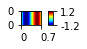

In [3]:
td[0].resize(16, td[0].m).plot()

In [4]:
from orbithunter.gluing import rediscretize_tileset, generate_symbol_arrays

In [5]:
td = rediscretize_tileset(td, new_shape=(16,16))
td

{0: EquilibriumOrbitKS({"shape": [16, 16], "basis": "field", "parameters": [0.0, 6.391, 0.0]}),
 1: RelativeOrbitKS({"shape": [16, 16], "basis": "field", "parameters": [17.151, 13.02, -3.313]}),
 2: AntisymmetricOrbitKS({"shape": [16, 16], "basis": "field", "parameters": [17.151, 17.591, 0.0]})}

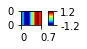

In [6]:
td[0].plot()

Generate all unique (up to symmetry) symbolic representations for a tile set of three tiles and shape (3, 3) 

In [7]:
glue_shape = (3, 3)
symbol_arrays = generate_symbol_arrays(td, glue_shape=glue_shape, unique=True)

In [8]:
tiling_example = orb.tile(symbol_arrays[1000], td, orb.OrbitKS,
                          include_zero_dimensions=False,
                          strip_wise=False)

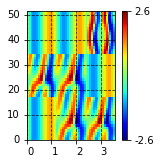

array([[0, 0, 2],
       [1, 1, 0],
       [0, 1, 1]])

In [9]:
tiling_example.plot()
symbol_arrays[1000]

In [10]:
X = []
symbol_y = []
converge_y = []
for sa in symbol_arrays:
    tiling = orb.tile(sa, td, orb.OrbitKS).resize(32,32)
    X.append(tiling.state)
    symbol_counter = Counter(sa.ravel().tolist())
    symbol_y.append([symbol_counter[0]/sa.size, symbol_counter[1]/sa.size, symbol_counter[2]/sa.size])
X = np.array(X)
X = np.reshape(X, (*X.shape, 1))
y = np.array(symbol_y)

If we use a softmax layer, the output can be interpreted as a probability, which means that the total is conserved, such that if we multiply by the number of symbols we can get back an estimate that conserves the number of tiles.  

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Activation
from sklearn.model_selection import train_test_split
X = np.abs(X)
X = (X - X.mean()) / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_size = X.shape[0]

cnn = Sequential()
cnn.add(Conv2D(filters=32, kernel_size=8, padding='valid', input_shape=X.shape[1:]
               ))
cnn.add(AveragePooling2D(pool_size=2))
cnn.add(Activation('relu'))

cnn.add(Conv2D(filters=8, kernel_size=8,
               padding='valid'
               ))
cnn.add(AveragePooling2D(pool_size=2))
cnn.add(Activation('relu'))
cnn.add(Flatten())
cnn.add(Dense(int(X[0].size)))
cnn.add(Dense(y.shape[1], activation='softmax'))
cnn.compile(loss='mse', optimizer='adam')

In [12]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 25, 25, 32)        2080      
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 12, 32)        0         
_________________________________________________________________
activation (Activation)      (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 8)           16392     
_________________________________________________________________
average_pooling2d_1 (Average (None, 2, 2, 8)           0         
_________________________________________________________________
activation_1 (Activation)    (None, 2, 2, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0

In [13]:
history = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=0, epochs=100)

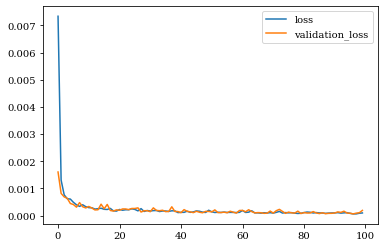

In [14]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False

_ = plt.plot(history.history['loss'])
_ = plt.plot(history.history['val_loss'])
_ = plt.legend(('loss', 'validation_loss'))
_ = plt.show()

In [15]:
example_orbit_ = orb.read_h5('./data/OrbitKS.h5', 't79p778_x37p297')

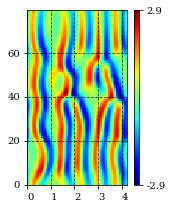

In [16]:
example_orbit_.plot()

In [17]:
example_orbit_ = example_orbit_.resize(32,32)

In [18]:
print('Example x', example_orbit_.x, 'Sum(x) for Tiles', td[0].x + td[1].x + td[2].x)

Example x 37.29708818660391 Sum(x) for Tiles 37.001204395011264


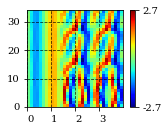

In [46]:
guess_symbol_array = np.array([[0,1,1],[0,1,1],[0,2,2]])
approximate_tiling = orb.tile(guess_symbol_array, td, orb.OrbitKS).resize(32, 32)
approximate_tiling.plot()

In [47]:
np.matrix(guess_symbol_array)

matrix([[0, 1, 1],
        [0, 1, 1],
        [0, 2, 2]])

In [48]:
test_converge_result = orb.hunt(approximate_tiling.transform(to='modes'),
                                method=('adj', 'lsmr'),
                                preconditioning=[True, False],
                                pexp=(1,4),
                           verbose=True)
test_tiling = test_converge_result.orbit


-------------------------------------------------------------------------------------------------
Starting adjoint descent
Initial guess : OrbitKS({"shape": [31, 30], "basis": "modes", "parameters": [34.302, 35.477, 0]})
Constraints : {'t': False, 'x': False, 's': True}
Initial cost : 4751.559956984409
Target cost tolerance : 1e-06
Maximum iteration number : 10000
Preconditioning : True
-------------------------------------------------------------------------------------------------
#################################################
 cost=0.4069249 after 5000 adjoint descent steps. Parameters=(34.678428196929744, 35.477627250387506, 0.0)
#################################################
maximum number of iterations reached, terminating with cost 0.25631016823743685.


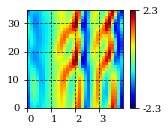

In [49]:
test_tiling.plot()

In [99]:
prediction_for_test = cnn.predict(test_tiling.transform(to='field').state.reshape(1, 32, 32, 1))
np.round(prediction_for_test * sa.size)

array([[9., 0., 0.]], dtype=float32)

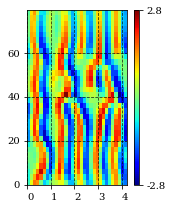

In [55]:
example_orbit_.plot()

In [56]:
prediction_for_target = cnn.predict(example_orbit_.transform(to='field').state.reshape(1, 32, 32, 1))
np.round(prediction_for_target * sa.size)

array([[9., 0., 0.]], dtype=float32)

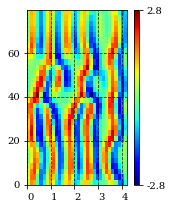

In [57]:
example_orbit_.transform(to='field').reflection().plot()

Because of how the padding in the convolutional layers works, however, 

In [58]:
prediction_for_target_reflection = cnn.predict(example_orbit_.transform(to='field').reflection().state.reshape(1, 32, 32, 1))
np.round(prediction_for_target_reflection * sa.size)

array([[2., 5., 2.]], dtype=float32)

In [71]:
predictions = []
for eo in example_orbit_.transform(to='field').group_orbit(roll=(8,8)):
    prediction_for_target_roll = cnn.predict((eo.state.reshape(1, 32, 32, 1)))
    predictions.extend(np.round(prediction_for_target_roll * sa.size))
        
predictions = np.array(predictions).reshape(-1, 3)

(array([753., 463., 288., 222., 150.,  86.,  53.,  27.,   5.,   1.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

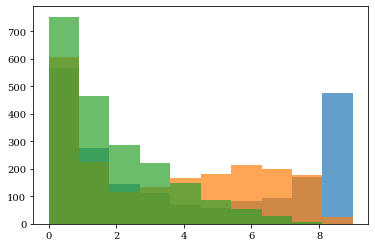

In [72]:
predictions
plt.hist(predictions[:, 0], alpha=0.7)
plt.hist(predictions[:, 1], alpha=0.7)
plt.hist(predictions[:, 2], alpha=0.7)

In [73]:
np.round(np.mean(predictions, axis=0))

array([4., 3., 2.], dtype=float32)

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(y_test, y_predict, s=5)
_ = ax.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()], color='r')
_ = plt.xlabel('True value')
_ = plt.ylabel('Predicted value')
_ = plt.show()

In [80]:
td = orb.rediscretize_tileset(td, new_shape=(32, 32))

In [85]:
import orbithunter.persistent_homology as orbgudhi

In [86]:
y_bottleneck = []
for sa in symbol_arrays:
    tiling = orb.tile(sa, td, orb.OrbitKS)
    y_bottleneck.append(orbgudhi.persistence_distance(tiling, example_orbit_, metric='bottleneck'))
y = np.array(y_bottleneck).reshape(-1,1)

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Activation
from sklearn.model_selection import train_test_split

X = (X - X.mean()) / X.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_size = X.shape[0]

bottleneck_cnn = Sequential()
bottleneck_cnn.add(Conv2D(filters=32, kernel_size=8, padding='valid', input_shape=X.shape[1:]
               ))
bottleneck_cnn.add(AveragePooling2D(pool_size=2))
bottleneck_cnn.add(Activation('relu'))

bottleneck_cnn.add(Conv2D(filters=8, kernel_size=8,
               padding='valid'
               ))
bottleneck_cnn.add(AveragePooling2D(pool_size=2))
bottleneck_cnn.add(Activation('relu'))
bottleneck_cnn.add(Flatten())
bottleneck_cnn.add(Dense(int(sample_size)))
bottleneck_cnn.add(Dense(y.shape[1], activation='relu'))
bottleneck_cnn.compile(loss='mse', optimizer='adam')
bottleneck_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 25, 25, 32)        2080      
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 12, 32)        0         
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 8)           16392     
_________________________________________________________________
average_pooling2d_3 (Average (None, 2, 2, 8)           0         
_________________________________________________________________
activation_3 (Activation)    (None, 2, 2, 8)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32)               

In [88]:
history = bottleneck_cnn.fit(X_train, y_train, validation_data=(X_test, y_test), verbose=1, epochs=100)

Epoch 1/100
55/55 [==============================] - 1s 15ms/step - loss: 19.9772 - val_loss: 0.1718
Epoch 2/100
55/55 [==============================] - 1s 14ms/step - loss: 0.0868 - val_loss: 0.0292
Epoch 3/100
55/55 [==============================] - 1s 15ms/step - loss: 0.0221 - val_loss: 0.0173
Epoch 4/100
55/55 [==============================] - 1s 13ms/step - loss: 0.0154 - val_loss: 0.0123
Epoch 5/100
55/55 [==============================] - 1s 13ms/step - loss: 0.0123 - val_loss: 0.0094
Epoch 6/100
55/55 [==============================] - 1s 13ms/step - loss: 0.0092 - val_loss: 0.0075
Epoch 7/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0075 - val_loss: 0.0064
Epoch 8/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 9/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0059 - val_loss: 0.0080
Epoch 10/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0052 - val_loss: 0.004

55/55 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 83/100
55/55 [==============================] - 1s 13ms/step - loss: 0.0021 - val_loss: 0.0045
Epoch 84/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 85/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 86/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0027 - val_loss: 7.9809e-04
Epoch 87/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0063 - val_loss: 0.0058
Epoch 88/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0298 - val_loss: 0.0103
Epoch 89/100
55/55 [==============================] - 1s 13ms/step - loss: 0.0057 - val_loss: 0.0060
Epoch 90/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0087 - val_loss: 0.0060
Epoch 91/100
55/55 [==============================] - 1s 12ms/step - loss: 0.0098 - val_loss: 0.0135

As a baseline, let's see how well it predicts the distance between the example orbit and itself: The expected value is of course, 0.

In [91]:
orbgudhi.persistence_distance(example_orbit_, example_orbit_, metric='bottleneck')

0.0

In [92]:
bottleneck_cnn.predict(example_orbit_.transform(to='field').state.reshape(1, 32, 32, 1))

array([[19.916237]], dtype=float32)

In [93]:
bottleneck_cnn.predict(test_tiling.transform(to='field').state.reshape(1, 32, 32, 1))

array([[14.348245]], dtype=float32)

In [94]:
y_predict = bottleneck_cnn.predict(X_test)

In [98]:
y_predict[0]

array([13.436473], dtype=float32)

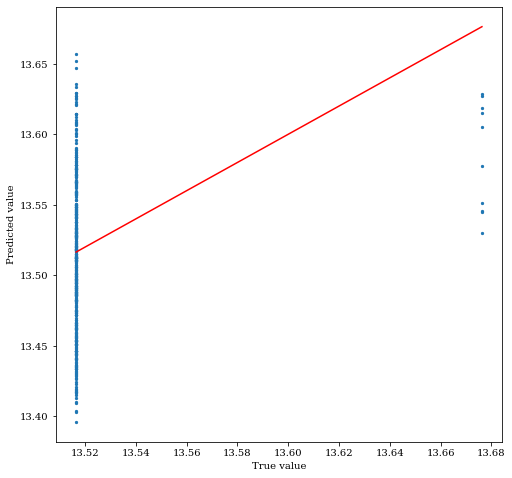

In [97]:
fig, ax = plt.subplots(figsize=(8,8))
_ = ax.scatter(y_test, y_predict, s=5)
_ = ax.plot([y_test.min(), y_test.max()],[y_test.min(),y_test.max()], color='r')
_ = plt.xlabel('True value')
_ = plt.ylabel('Predicted value')
_ = plt.show()

In [ ]:
X, y = list_of_orbits, list_of_predictive_quantities
orbit_cnn(X, y)